# Predicting used car prices in the UK market
_Author: Kostas Batsis_ <br>
_Date: 21/12/2020_

### Introduction

This project concerns the construction of a linear regression model for the prediction of used car prices in the UK market. It is based on datasets of 99,187 scraped used car listings, split into car brand, [recovered from kaggle](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes/tasks?taskId=1258). These include variables on model, prices, mileage, miles per gallon, engine size, year of production, transmission type, fuel type and two tax-related variables. I merged the sets into a single dataset and added the car brand as an extra variable. I decided to drop the model variable as it would create a large number of individual dummy variables (194 for a total of 195 models) and to substitute it with the variable indicating the car brand. I also dropped the tax variables based on an a-priori judgement of them playing no important role in predicting a car price. Price will serve as the dependent variable and the remaining variables will serve as the independent variables. The analysis was performed with Anaconda Python 3.8.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import mean,std
from sklearn import linear_model
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

In [2]:
carData = pd.DataFrame()
dirEntries = os.listdir('cardata_kaggle')
for entry in dirEntries:
        currentFrame = pd.read_csv('cardata_kaggle/'+entry)
        currentFrame['Brand'] = entry.split('.')[0]
        carData = carData.append(currentFrame,ignore_index=True)
print(carData.head(5),'\n')
print('Total sample size:',len(carData))
print('Total models:',len(carData['model'].unique()))
carData = carData.drop('model',axis=1)
carData = carData.drop('tax',axis=1)
carData = carData.drop('tax(£)',axis=1)

  model  year  price transmission  mileage fuelType    tax   mpg  engineSize  \
0    A1  2017  12500       Manual    15735   Petrol  150.0  55.4         1.4   
1    A6  2016  16500    Automatic    36203   Diesel   20.0  64.2         2.0   
2    A1  2016  11000       Manual    29946   Petrol   30.0  55.4         1.4   
3    A4  2017  16800    Automatic    25952   Diesel  145.0  67.3         2.0   
4    A3  2019  17300       Manual     1998   Petrol  145.0  49.6         1.0   

  Brand  tax(£)  
0  audi     NaN  
1  audi     NaN  
2  audi     NaN  
3  audi     NaN  
4  audi     NaN   

Total sample size: 99187
Total models: 195


### Exploratory Data Analysis

I first searched for missing data of which there were none.

In [3]:
print(carData.isnull().sum(),'\n')

year            0
price           0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
Brand           0
dtype: int64 



Then I created the dummy variables for each categorical variable in the dataset. Counts are presented below for each of these variables before the transformation. Note that the other transmission type category as well as the electric car category have very low counts (9 and 6 respectively).

In [4]:
print(carData['Brand'].value_counts(),'\n')
dummy = pd.get_dummies(carData['Brand'],drop_first=True)
carData = pd.concat([carData,dummy],axis=1)
print(carData['transmission'].value_counts(),'\n')
dummy = pd.get_dummies(carData['transmission'],drop_first=True)
carData = pd.concat([carData,dummy],axis=1)
print(carData['fuelType'].value_counts(),'\n')
dummy = pd.get_dummies(carData['fuelType'],drop_first=True)
carData = pd.concat([carData,dummy],axis=1)

ford        17965
vw          15157
vauxhall    13632
merc        13119
bmw         10781
audi        10668
toyota       6738
skoda        6267
hyundi       4860
Name: Brand, dtype: int64 

Manual       56445
Semi-Auto    22677
Automatic    20056
Other            9
Name: transmission, dtype: int64 

Petrol      54928
Diesel      40928
Hybrid       3078
Other         247
Electric        6
Name: fuelType, dtype: int64 



I proceeded with exploring the numerical variables. Histrograms are presented for each.

Text(0.5, 1.0, 'Miles per gallon')

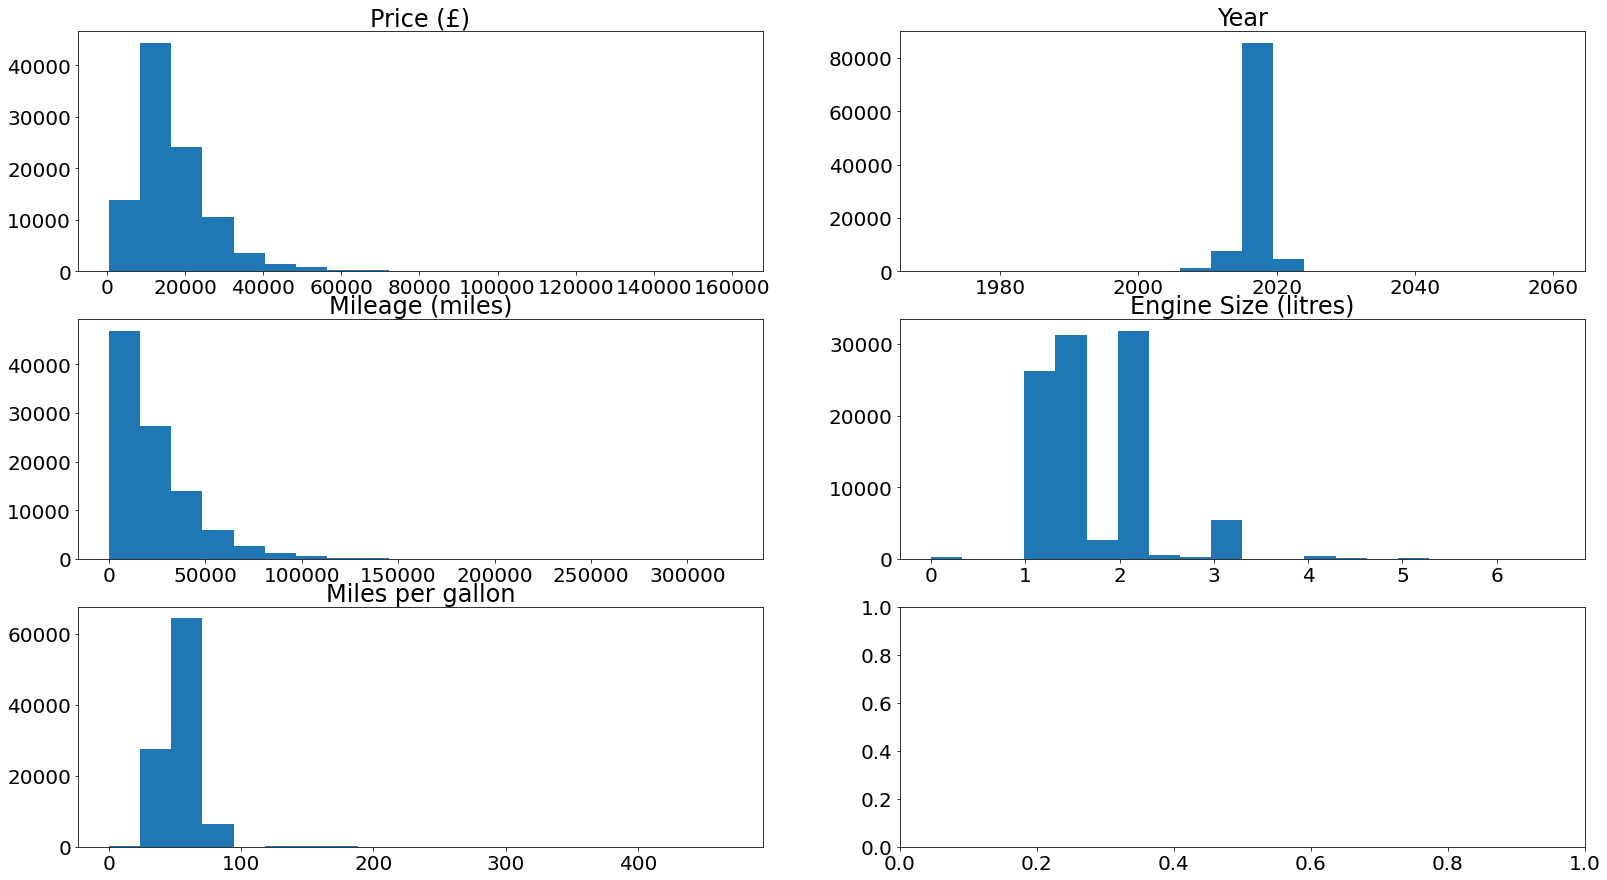

In [5]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(3,2,figsize=(27,15))
axs[0,0].hist(carData['price'],bins=20)
axs[0,0].set_title('Price (£)')
axs[0,1].hist(carData['year'],bins=20)
axs[0,1].set_title('Year')
axs[1,0].hist(carData['mileage'],bins=20)
axs[1,0].set_title('Mileage (miles)')
axs[1,1].hist(carData['engineSize'],bins=20)
axs[1,1].set_title('Engine Size (litres)')
axs[2,0].hist(carData['mpg'],bins=20)
axs[2,0].set_title('Miles per gallon')

All variables except for year have a positive skew. Year includes a non-sensical value of 2060 which I removed. Engine size also includes 273 illogical values of zero. An examinantion of these data revealed no obvious patterns (see below for a sample). Most of these cases concern cars which burn conventional fuels and therefore should have non-zero engine sizes, with the possible exception of two electric cars and one car belonging to the other category. I removed all cases where engine size equaled zero and since the sample size of electric cars is small (n=6) and engine size has no direct meaning for these cars I excluded this category from my analysis.

In [6]:
carData = carData.drop(index=carData[carData['year']==2060].index) 
pd.set_option("display.max_rows", 300)
zeroEngSample = carData[carData['engineSize']==0.0]
print('Total zero engine size cases: ',len(zeroEngSample),'\n')
zeroEngPrintOut = zeroEngSample.iloc[:,0:8]
zeroEngPrintOut = zeroEngPrintOut.drop('engineSize',axis=1)
print(zeroEngPrintOut.sample(30))

Total zero engine size cases:  273 

       year  price transmission  mileage fuelType    mpg     Brand
7670   2020  37888    Automatic      285   Petrol   30.7      audi
7647   2020  31990    Automatic     1500   Petrol   40.4      audi
16170  2017  18995    Automatic    33021   Hybrid  470.8       bmw
39467  2016  11300       Manual    37993   Diesel   61.7    hyundi
37778  2017   9046       Manual    22000   Petrol   65.7      ford
7518   2020  29944    Automatic     1500   Petrol   32.5      audi
62833  2017  15400    Automatic    19576   Diesel   61.4     skoda
73275  2015   7800    Automatic    32484   Petrol   47.9  vauxhall
43658  2016   6300       Manual    17272   Petrol   61.4    hyundi
19365  2001  13000       Manual    22633   Petrol   53.3       bmw
37811  2017   9951       Manual    15000   Petrol   52.3      ford
7611   2020  32444    Automatic     1500   Petrol   31.4      audi
90381  2017  16000       Manual    13593   Diesel   68.9        vw
37771  2018   9999       

In [7]:
print('\n',carData[carData['engineSize']==0.0].fuelType.value_counts(),'\n')
carData = carData.drop(carData[carData['engineSize']==0.0].index,axis=0)
carData = carData.drop('Electric',axis=1)


 Petrol      163
Diesel       69
Hybrid       38
Electric      2
Other         1
Name: fuelType, dtype: int64 



Histograms of the two modified variables follow. Year has now a negative skew.

Text(0.5, 1.0, 'Engine Size (litres)')

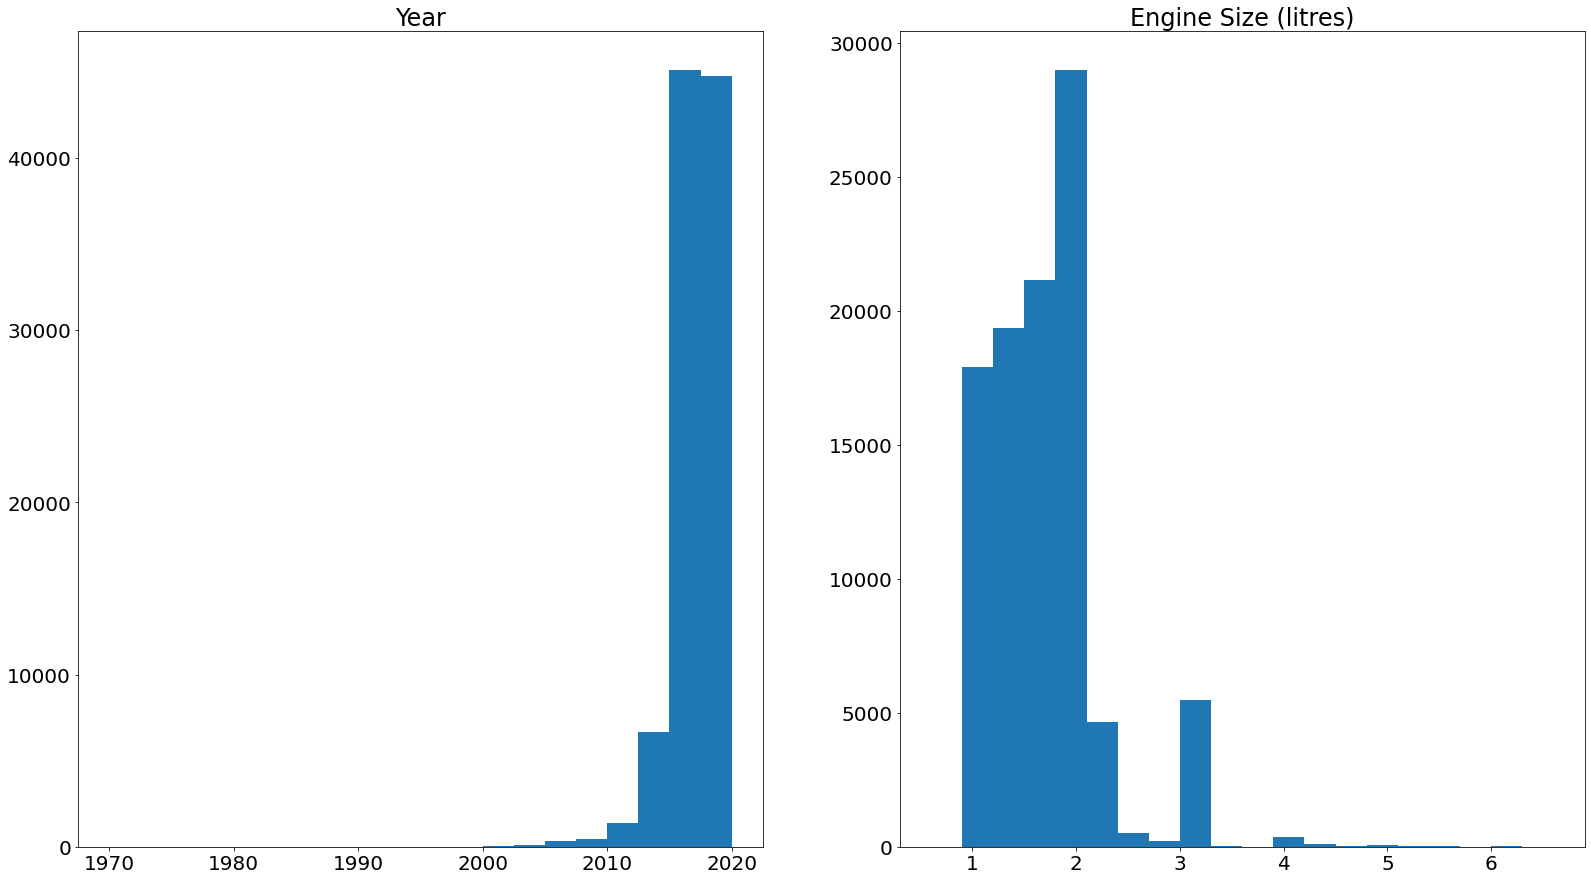

In [8]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1,2,figsize=(27,15))
axs[0].hist(carData['year'],bins=20)
axs[0].set_title('Year')
axs[1].hist(carData['engineSize'],bins=20)
axs[1].set_title('Engine Size (litres)')

To examine for multivariate outliers among the numerical IVs I used the Mahalanobis distance. The distances of the cases ranged from 0.07 to about 2,512 so I chose to examine cases with a distance greater than 500 for any abnormalities. These data are presented below and all values look normal. The largest distance concerns a very old car dating from 1970. I proceeded with the conclusion of no problems with multivariate outliers being present.

In [9]:
robustCov = MinCovDet().fit(carData[['year','mileage','mpg','engineSize']])
maha = robustCov.mahalanobis(carData[['year','mileage','mpg','engineSize']])
print('Mahalanobis min:',maha.min(),'Mahalanobis max:',maha.max())
carData['mahalanobis'] = maha
mahaOutliers = carData[carData['mahalanobis']>500]
print('\n',mahaOutliers[['year','mileage','mpg','engineSize','mahalanobis']])

Mahalanobis min: 0.07131635924208594 Mahalanobis max: 2511.36502587755

        year  mileage    mpg  engineSize  mahalanobis
9822   2008   323000   44.1         2.0  1145.907620
10700  2016    25269  470.8         0.6  1879.853475
18856  2015    59000  470.8         0.6  1829.179950
19288  2017    32867  470.8         0.6  1886.897127
19503  2015    29465  470.8         1.0  1879.417384
20293  1996    36000   26.4         2.8   513.508563
20748  2017    19178  470.8         0.6  1903.978873
20754  2017    23956  470.8         0.6  1897.268550
20993  2016    41063  470.8         0.6  1860.751150
21198  2017    50867  470.8         0.6  1874.458515
55618  2010   259000   30.7         3.0   733.433405
57178  2016   240494   68.9         2.1   794.881983
62978  2010   250650   57.6         1.9   647.719418
63462  2010   300000   57.6         1.9  1015.550678
63485  2009   241565   47.9         1.9   571.739494
81217  2013   279000   55.4         1.7   977.229262
81235  1970    37357   42.

Then I created the IV matrix and the DV vector.

In [10]:
xSet = carData.drop(['price','transmission','Brand','fuelType','mahalanobis'],axis=1)
ySet = carData['price']

At the next step of the analysis I examined multicollinearity among the IVs using the variance inflation factor. The VIFs are presented below and we see that the year, mpg and engine size variables all have very high factors indicating the presence of severe multicollinearity. Despite this, since multicollinearity does not influence the predictions, the precision of the predictions and the goodness-of-fit statistics I proceeded without any corrective measures. I will also later run a Lasso regression, a method which is tolerant to multicollinearity.

In [11]:
vifData = pd.DataFrame()
vifData['Regressor'] = xSet.columns
vifData['VIF'] = [variance_inflation_factor(xSet.values, i) for i in range(len(xSet.columns))] 
print(vifData)

     Regressor         VIF
0         year  113.510705
1      mileage    2.525250
2          mpg   32.876090
3   engineSize   26.231932
4          bmw    2.083276
5         ford    3.097059
6       hyundi    1.553881
7         merc    2.357883
8        skoda    1.671133
9       toyota    2.039270
10    vauxhall    2.599783
11          vw    2.539163
12      Manual    5.907032
13       Other    1.000699
14   Semi-Auto    2.327071
15      Hybrid    1.750421
16       Other    1.044865
17      Petrol    4.529527


Next I fitted a regression equation to the data with sole purpose of examining residual plots and checking the linear regression assumptions. The plot is presented below and I observed important problems with heteroscedasticity and non-linearity. I also observed an outlier in the solution which turned out to be the 1970 car with the highest Mahalanobis distance. I removed the outlier keeping in mind that models of the data might break down for very old cars. Then I performed a natural logarithm transformation of the dependent variable (price).

I fitted the equation again and the results are shown in the second residual plot below. Now the assumptions of linearity, homoscedasticity and normality are met to a reasonable degree.

Text(0, 0.5, 'Residuals')

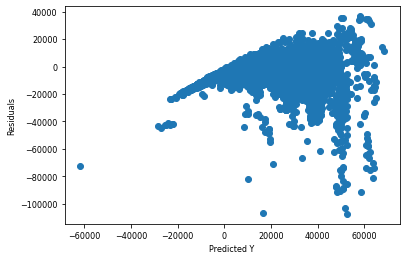

In [12]:
residualsModel = linear_model.LinearRegression() 
residualsModel.fit(xSet,ySet)
fig = plt.figure()
plt.rcParams.update({'font.size': 8})
predictedValues = residualsModel.predict(xSet)
plt.scatter(predictedValues,predictedValues-ySet,label='Residual Plot') 
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')

Outlier data:
        year  mileage   mpg  engineSize
81235  1970    37357  42.2         1.4


Text(0, 0.5, 'Residuals')

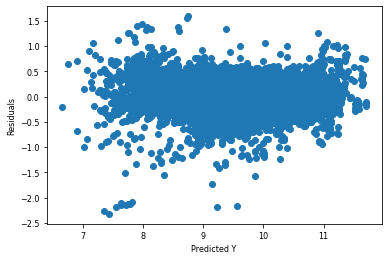

In [13]:
predY = residualsModel.predict(xSet)
outIndex = np.where(predY==predY.min())
outIndex = outIndex[0]
print('Outlier data:\n',xSet.iloc[outIndex,0:4])
outIndex = xSet[xSet['year']==1970].index
xSet = xSet.drop(index=outIndex)
ySet = ySet.drop(index=outIndex)
ySet = np.log(ySet)
residualsModel = linear_model.LinearRegression(fit_intercept=True) 
residualsModel.fit(xSet,ySet)
fig = plt.figure()
predictedValues = residualsModel.predict(xSet)
plt.scatter(predictedValues,predictedValues-ySet,label='Residual Plot') 
plt.xlabel('Predicted Y')
plt.ylabel('Residuals')

I also ran a Durbin-Watson test whose value of 1.52 indicates a lack of problems with non-independence of errors.

In [14]:
print('\nDurbin-Watson:',durbin_watson(predictedValues-ySet))


Durbin-Watson: 1.5195224614468505


### Regression Modeling

I first built a linear regression model with a 10-fold cross-validation. R^2 and mean absolute error statistics are presented below as are the coefficents of the last fold's model. I obtained a high mean R^2 (0.885, sd: 0.002) and a moderate-to-low mean MAE (-0.138, sd: 0.001) which indicate the predictive value of the model.

In [15]:
model = linear_model.LinearRegression(fit_intercept=True) 
cv = KFold(n_splits=10,random_state=1,shuffle=True)
results = cross_validate(model,xSet,ySet,scoring=('r2','neg_mean_absolute_error'),cv=cv,n_jobs=-1,return_estimator=True)

print('R^2: %.3f (%.3f)' % (mean(results['test_r2']),std(results['test_r2'])))
print('MAE: %.3f (%.3f)' % (mean(results['test_neg_mean_absolute_error']),std(results['test_neg_mean_absolute_error'])))
modelCoef = pd.DataFrame()
modelCoef['Regressor']=xSet.columns
modelCoef['Coefficients']=results['estimator'][-1].coef_
print('\n',modelCoef)

R^2: 0.885 (0.002)
MAE: -0.138 (0.001)

      Regressor  Coefficients
0         year      0.115864
1      mileage     -0.000005
2          mpg     -0.004389
3   engineSize      0.360238
4          bmw     -0.110828
5         ford     -0.250865
6       hyundi     -0.382789
7         merc     -0.028480
8        skoda     -0.282168
9       toyota     -0.418329
10    vauxhall     -0.457541
11          vw     -0.165858
12      Manual     -0.124992
13       Other      0.033844
14   Semi-Auto      0.010831
15      Hybrid      0.328072
16       Other      0.201975
17      Petrol     -0.066845


To finish the analysis I also ran a Lasso regression to see if it would enhance prediction. Lasso is an Ordinary Least Squares regession with an L1 penalty term which achieves: a) feature selection by setting excluded coefficients to zero and b) tolerance to multicollinearity. To meet the Lasso assumptions I standardized the numerical IVs and centered the DV, seperately in each fold. I implemented the Lasso regression with scikit-learn's LassoCV method which performs automatic tuning of the Lasso hyperparameter. Once again I used 10-fold cross-validation and R^2 and mean absolute error (in the original units) stastistics are presented below. We see that the results are identical to the standard OLS procedure and therefore I concluded that Lasso is not a productive approach for this analysis.

In [16]:
preprocessor = ColumnTransformer(
    [
        ('scaler',StandardScaler(),['year','mileage','engineSize','mpg'])
    ],
    remainder = 'passthrough'
)

lfolds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
pipeline = Pipeline(steps=[('scaler',preprocessor), ('lasso', LassoCV(alphas=np.arange(0, 1, 0.01),cv=lfolds))])
model = TransformedTargetRegressor(regressor=pipeline,transformer=StandardScaler(with_std=False))

cv = KFold(n_splits=10,random_state=1,shuffle=True)
lresults = cross_validate(model,xSet,ySet,scoring=('r2','neg_mean_absolute_error'),cv=cv,n_jobs=-1)

print('R^2: %.3f (%.3f)' % (mean(lresults['test_r2']),std(lresults['test_r2'])))
print('MAE: %.3f (%.3f)' % (mean(lresults['test_neg_mean_absolute_error']),std(lresults['test_neg_mean_absolute_error'])))

R^2: 0.885 (0.002)
MAE: -0.138 (0.001)
